In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math, itertools, sys, os, pickle


BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, BASE_DIR)
from config import device
from assistive_functions import *
from loss_functions import LQLossFH
from controllers.empirical_controller import *
from experiments.scalar.LTI_sys import LTI_system
from experiments.scalar.assistive_functions import load_data


num_sampled_controllers = 20
dist_type = 'N biased'
T = 10

random_seed = 33
random_state = np.random.RandomState(random_seed)


# Load empirical controllers and evaluate

In [5]:
sys_np = LTI_system(
    A = np.array([[0.8]]),  # num_states*num_states
    B = np.array([[0.1]]),  # num_states*num_inputs
    C = np.array([[0.3]]),  # num_outputs*num_states
    x_init = 2*np.ones((1, 1)),  # num_states*1
    use_tensor=False
)
sys = LTI_system(
    sys_np.A, sys_np.B, sys_np.C, sys_np.x_init,
    use_tensor=True
)

file_path = os.path.join(BASE_DIR, 'experiments', 'scalar', 'saved_results')

# load data
_, data_test, disturbance = load_data(
    dist_type=dist_type, S=None, # do not need train data
    T=T, random_seed=random_seed,
    S_test=None   # use a subset of available test data if not None
)

# loss
Q = 5*torch.eye(sys.num_states).to(device)
R = 0.003*torch.eye(sys.num_inputs).to(device)
loss_bound = 1
sat_bound = torch.matmul(torch.matmul(torch.transpose(sys.x_init, 0, 1), Q) , sys.x_init)
lq_loss_bounded = LQLossFH(Q, R, T, loss_bound, sat_bound)
lq_loss_original = LQLossFH(Q, R, T, None, None)

# generic empirical controller
controller_gen = EmpCont(
    sys=sys, train_d=torch.zeros((1, T, sys.num_states)), 
    lr=0.5, loss=None, random_seed=None, optimizer='AdamW'
)

Ss = np.logspace(2, 15, num=14, base=2, dtype=int)
emp_loss_bounded = dict.fromkeys(Ss)
emp_loss_original = dict.fromkeys(Ss)
for S in Ss:
    # load empirical controller params
    filename = dist_type.replace(" ", "_")+'_emp_T'+str(T)+'_S'+str(S)+'.pkl'
    filename = os.path.join(file_path, filename)
    if not os.path.exists(filename):
        continue
    filehandler = open(filename, 'rb')
    dict_cont = pickle.load(filehandler)
    filehandler.close()
    controller_gen.controller.out.weight = to_tensor(dict_cont['weight']).to(device)
    controller_gen.controller.out.bias = to_tensor(dict_cont['bias']).to(device)
    print('[INFO] empirical controller with S='+str(S)+' and T='+str(T)+' loaded.')
    # rollout
    with torch.no_grad():
        states, resp, inputs = controller_gen.multi_rollout(data_test[dist_type])
    
    # loss
    emp_loss_bounded[S] = lq_loss_bounded.forward(states, inputs).item()
    emp_loss_original[S] = lq_loss_original.forward(states, inputs).item()

# ------ LOAD BENCHMARK AND EVALUATE ------

# load benchmark controller params
filename = dist_type.replace(" ", "_")+'_bnc_T'+str(T)+'.pkl'
filename = os.path.join(file_path, filename)
filehandler = open(filename, 'rb')
dict_bnc = pickle.load(filehandler)
filehandler.close()
controller_gen.controller.out.weight = to_tensor(dict_bnc['weight']).to(device)
controller_gen.controller.out.bias = to_tensor(dict_bnc['bias']).to(device)
print('[INFO] benchmark controller with T='+str(T)+' loaded.')
print(dict_bnc)

# rollout
with torch.no_grad():
    states, resp, inputs = controller_gen.multi_rollout(data_test[dist_type])

# loss
bnc_loss_bounded = lq_loss_bounded.forward(states, inputs).item()
bnc_loss_original = lq_loss_original.forward(states, inputs).item()


[INFO] empirical controller with S=4 and T=10 loaded.
[INFO] empirical controller with S=8 and T=10 loaded.
[INFO] empirical controller with S=16 and T=10 loaded.
[INFO] empirical controller with S=32 and T=10 loaded.
[INFO] empirical controller with S=64 and T=10 loaded.
[INFO] empirical controller with S=128 and T=10 loaded.
[INFO] empirical controller with S=256 and T=10 loaded.
[INFO] empirical controller with S=512 and T=10 loaded.
[INFO] empirical controller with S=1024 and T=10 loaded.
[INFO] benchmark controller with T=10 loaded.
{'weight': tensor([-7.4378]), 'bias': tensor([-3.])}


# UB vs test loss diff S and prior
NOTE: results for performance of the sampled controllers and upper bounds should be calculated by running ub_ablation.py

/Users/clara/anaconda3/anaconda3/envs/PAC-bayes/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#023eff'` for the same effect.

  func(*plot_args, **plot_kwargs)


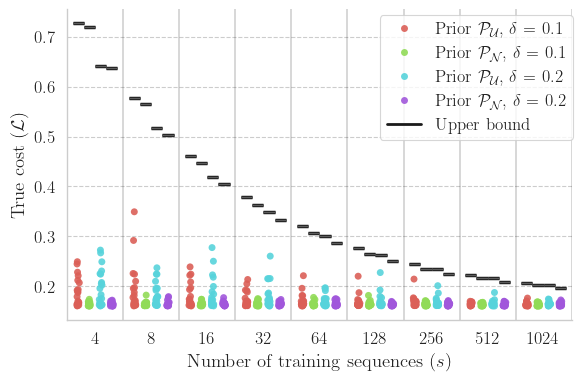

In [6]:
from matplotlib.lines import Line2D

# ------ format ------
plt.rcParams['text.usetex'] = True
sns.set_theme(
    context='paper', style='whitegrid', palette='bright', 
    font='sans-serif', font_scale=1.4, color_codes=True, rc=None, 
)
sns.set_style({'grid.linestyle': '--'})
mpl.rc('font', family='serif', serif='Times New Roman')


# ------ init ------
ub_dict = dict.fromkeys([
    'number of training rollouts', 'prior_type_b', 'bounded true loss', 
    'av_test_loss_original', 'ub', 'ub_sb', 'sampled controller number', 
    'epsilon', 'setup', 'emp_loss_bounded', 'emp_loss_original'
])
epsilons = [0.1, 0.2]
ptypes = ['Uniform', 'Gaussian_biased_wide']
num_rows = len(epsilons)*len(Ss)*len(ptypes)*num_sampled_controllers
for key in ub_dict.keys():
    ub_dict[key] = [None]*num_rows
ind = 0

# ------ loop over setups ------
file_path = os.path.join(BASE_DIR, 'experiments', 'scalar', 'saved_results')
for s_tmp in Ss: 
    # ------ load sample-based upper bounds ------
    filename = os.path.join(file_path, dist_type.replace(" ", "_")+'_ubsb_S'+str(s_tmp)+'.pkl')
    if not os.path.exists(filename):
        df_ubsb = None
    else:
        filehandler = open(filename, 'rb')
        try:
            res_ubsb = pickle.load(filehandler)
            df_ubsb = pd.DataFrame(res_ubsb)
        except:
            res_ubsb = None
            df_ubsb = None
        filehandler.close()
    # n_p and delta_hat saved in the dict. n_p can be different in each setup

    for eps, prior_type_b in itertools.product(epsilons, ptypes):
        # sample-based upper bound for this setup
        if df_ubsb is None:
            ubsb = None
        else:
            print(df_ubsb.keys())
            df_row = df_ubsb.loc[df_ubsb['delta']==eps].loc[df_ubsb['prior_type_b']==prior_type_b].loc[df_ubsb['S']==s_tmp]
            assert len(df_row)<=1
            ubsb = df_row['ub_sb'].item() if len(df_row)==1 else None

        # load
        filename = dist_type.replace(" ", "_")+'_ours_'+prior_type_b+'_T'+str(T)+'_S'+str(s_tmp)+'_eps'+str(int(eps*10))+'.pkl'
        filename = os.path.join(file_path, filename)
        if not os.path.exists(filename):
            continue
        filehandler = open(filename, 'rb')
        res = pickle.load(filehandler)
        filehandler.close()

        assert num_sampled_controllers==len(res['av_test_loss_original'])
        if prior_type_b=='Gaussian_biased':
            prior_name_b = '$\mathcal{N}(0.3, 1)$'
        elif prior_type_b=='Gaussian_biased_wide':
            prior_name_b = '$\mathcal{P}_\mathcal{N}$' #'$\mathcal{N}(0.3, 1.5^2)$'
        elif prior_type_b=='Uniform':
            prior_name_b = '$\mathcal{P}_\mathcal{U}$' #'$\mathcal{U}(-5.0, 5.0)$'
        else:
            prior_name_b = prior_type_b

        # set properties
        for sample_num in range(num_sampled_controllers):
            ub_dict['epsilon'] = eps
            ub_dict['number of training rollouts'][ind] = int(s_tmp)
            ub_dict['prior_type_b'][ind] = prior_type_b
            ub_dict['bounded true loss'][ind] = res['av_test_loss_bounded'][sample_num]
            ub_dict['av_test_loss_original'][ind] = res['av_test_loss_original'][sample_num]
            ub_dict['ub'][ind] = res['ub'].item()
            ub_dict['ub_sb'][ind] = ubsb
            ub_dict['sampled controller number'][ind] = sample_num
            ub_dict['emp_loss_bounded'][ind] = emp_loss_bounded[s_tmp]
            ub_dict['emp_loss_original'][ind] = emp_loss_original[s_tmp]
            ub_dict['setup'][ind] = 'Prior ' + prior_name_b + ', $\delta$ = ' + str(eps)
            ind = ind + 1
# assert ind==num_rows
df = pd.DataFrame(ub_dict)


# ------------------
# ------ PLOT ------
# ------------------
# only used to create a proper FacetGrid
g = sns.catplot(
    data=df, x='number of training rollouts', y='ub', #col='disturbance type',
    hue='setup', kind='box', height=4, aspect=1.5,
    sharey=False, palette='hls', legend=False
)

# mark upper bounds
g.map_dataframe(
    sns.boxenplot, x='number of training rollouts', y='ub', 
    linewidth=2, linecolor='k', alpha = 0.6,
    hue='setup', legend=False, # dodge=True, 
)

# mark sample-based upper bounds
# g.map_dataframe(
#     sns.boxenplot, x='number of training rollouts', y='ub_sb', 
#     linewidth=2, linecolor='blue', alpha = 0.6,
#     hue='setup', legend=False, # dodge=True, 
# )

# mark sampled controllers performance
g.map_dataframe(
    sns.stripplot, x='number of training rollouts', y='bounded true loss', 
    hue='setup', palette='hls', alpha=0.9, dodge=True
)

# add legend for the upper bound
custom_line = [Line2D([0], [0], color='k', lw=2)]

# ------ legends and titles ------
ax = g.axes[0,0]
# add vertical lines between groups
[ax.axvline(x+.5,color='k', alpha=0.2) for x in ax.get_xticks()]

# change xtick labels to integer without the leading 0 
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticks(ax.get_xticks(), [str(int(float(label))) for label in labels])

# axis labels
ax.set_xlabel(r'Number of training sequences ($s$)')
ax.set_ylabel(r'True cost ($\mathcal{L}$)')

# legend
handles, labels = ax.get_legend_handles_labels()
handles = handles+custom_line
labels = labels + ['Upper bound']
l = plt.legend(
    handles, labels, bbox_to_anchor=(0.62, 0.98), 
    loc=2, borderaxespad=0.
)
# ---------------------------------
filename = os.path.join(file_path, 'ub.pdf')
plt.savefig(filename)
plt.show()


# Heatmap

0.0005382061053202089
0.0012365450953705874
0.0012190713940193397
0.0016771085221038361


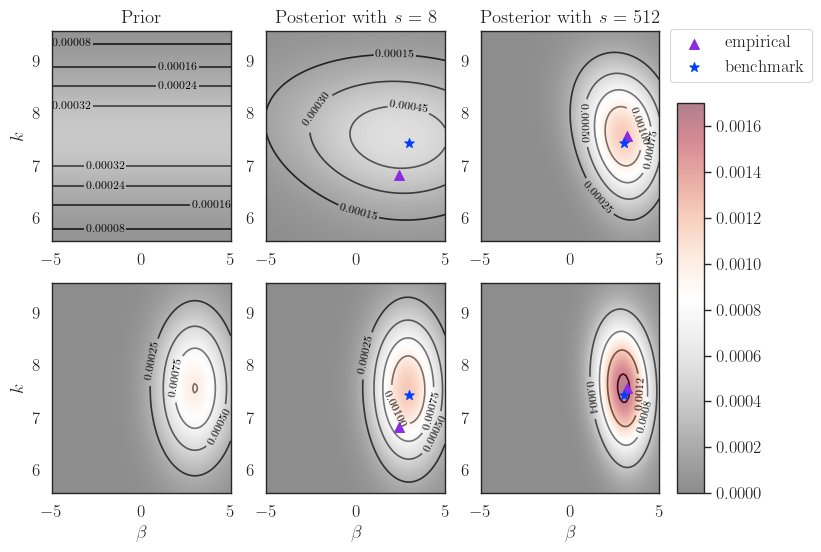

In [7]:
save_fig=True
marker_size=50


# ------ format ------
plt.rcParams['text.usetex'] = True
sns.set_theme(context='paper', style='white', palette='bright', font='sans-serif', font_scale=1.4, color_codes=True, rc=None)
mpl.rc('font', family='serif', serif='Times New Roman')
# ------

Ss_heat = [8, 512]
prior_types = ['Uniform', 'Gaussian_biased_wide']
plot_samples = False
eps_heat = 0.2
fig, axs = plt.subplots(len(prior_types), len(Ss_heat)+1,figsize=(3*(len(Ss_heat)+1),3*len(prior_types)))

file_path = os.path.join(BASE_DIR, 'experiments', 'scalar', 'saved_results')

for s_ind, s_tmp in enumerate(Ss_heat):
    for p_ind, prior_type_b in enumerate(prior_types):
        # load
        filename = dist_type.replace(" ", "_")+'_ours_'+prior_type_b+'_T'+str(T)+'_S'+str(s_tmp)+'_eps'+str(int(eps_heat*10))+'.pkl'
        filename = os.path.join(file_path, filename)
        if not os.path.exists(filename):
            continue
        filehandler = open(filename, 'rb')
        res_dict = pickle.load(filehandler)
        filehandler.close()
        
        res_dict['theta_grid'] = [k[0,0] for k in res_dict['theta_grid']]
        res_dict['theta'] = [k[0,0] for k in res_dict['theta']]

        theta_grid = np.array(res_dict['theta_grid'])
        bias_grid = np.array(res_dict['bias_grid'])
        X = -bias_grid
        Y = -theta_grid
        Z_prior = np.reshape(
            np.array(res_dict['prior']),
            (len(theta_grid), len(bias_grid))
        )
        Z_posterior = np.reshape(
            np.array(res_dict['posterior']),
            (len(theta_grid), len(bias_grid))
        )
        assert sum(sum(Z_prior))<=1+1e-5
        assert abs(sum(sum(Z_posterior))-1)<=1e-5

        # extend to negative side
        if X[0]*X[-1]>=0:
            d = np.mean(X[1:]-X[0:-1])
            stop = X[0] - d
            num = int(np.round((stop-(-5))/d))
            start = stop - num*d
            X_ext = np.concatenate((np.linspace(start, stop, num, endpoint=True), X))
            Z_prior_ext = np.concatenate(
                (np.zeros((Z_prior.shape[0], num)), Z_prior), axis=1
            )
            assert Z_prior_ext.shape==(len(Y), len(X_ext))
            Z_posterior_ext = np.concatenate(
                (np.zeros((Z_posterior.shape[0], num)), Z_posterior), axis=1
            )
            assert Z_posterior_ext.shape==(len(Y), len(X_ext))
        else:
            X_ext, Z_prior_ext, Z_posterior_ext = X, Z_prior, Z_posterior
        print(np.max(np.max(Z_posterior)))
        # u = -(theta x + bias) => multiply everything by -1
        # X, Y, X_ext = -X, -Y, -X_ext

        # ------ plot ------
        vmin = 0
        if Ss_heat[-1]==64:
            vmax = 0.0020
        elif Ss_heat[-1]==512:
            vmax = 0.0017
        elif Ss_heat[-1]==1024:
            vmax = 0.0019
        else:
            vmax=0.0013

        assert vmax>=np.max(np.max(Z_posterior))
        for ind in range(2):
            if ind==0 and s_ind>0:
                continue
            col_ind = 0 if (ind==0 and s_ind==0) else s_ind+1
            Z = Z_prior if col_ind==0 else Z_posterior
            Z_ext = Z_prior_ext if col_ind==0 else Z_posterior_ext
            axs[p_ind, col_ind].set_xlim([-5,5])
            im = axs[p_ind, col_ind].imshow(
                Z_ext, origin='lower', extent=[X_ext[0], X_ext[-1], Y[0], Y[-1]],
                cmap='RdGy_r', alpha=0.5, aspect='auto', vmin=vmin, vmax=vmax, interpolation='bilinear')
            contours = axs[p_ind, col_ind].contour(X, Y, Z, 4, colors='black', zorder=-1)
            axs[p_ind, col_ind].clabel(contours, inline=True, fontsize=8)

        # 4. samples from gridded-Gibbs
        if plot_samples:
            for ind, sc in enumerate(res_dict['sampled_controllers']):
                label = 'sampled' if ind==0 else None
                sc = (-sc[0], -sc[1])
                axs[p_ind, s_ind+1].scatter(sc[1], sc[0], c='c', s=marker_size/5)
        # 1. fitted empirical
        filename = dist_type.replace(" ", "_")+'_emp_T'+str(T)+'_S'+str(s_tmp)+'.pkl'
        filename = os.path.join(file_path, filename)
        if not os.path.exists(filename):
            continue
        filehandler = open(filename, 'rb')
        dict_cont = pickle.load(filehandler)
        filehandler.close()
        axs[p_ind, s_ind+1].scatter(-dict_cont['bias'], -dict_cont['weight'], c='m', s=marker_size, marker="^", label='empirical')
        # 6. benchmark
        if not dict_bnc is None:
            axs[p_ind, s_ind+1].scatter(
                -dict_bnc['bias'], -dict_bnc['weight'], c='b', marker='*', 
                s=marker_size, label='benchmark'
            )
    
    # set title
    axs[0, s_ind+1].set_title(r'Posterior with $s=$ '+str(s_tmp)) # ={:%d}
axs[0, 0].set_title('Prior')

# inside: loc='upper left'
axs[0,-1].legend(bbox_to_anchor=(1.9, 1.05))   # loc of upper-right corner of the legend. increasing moves it right and up 
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.03, 0.65])
fig.colorbar(im, cax=cbar_ax)



for s_ind in range(len(Ss_heat)+1):
    axs[-1, s_ind].set_xlabel(r'$\beta$')
for p_ind in range(len(prior_types)):
    axs[p_ind, 0].set_ylabel(r'$k$')

if save_fig:
    filename = dist_type.replace(" ", "_")+'_'+prior_type_b+'_contour_T'+str(T)+'_S'+str(S)+'.pdf'
    filename = os.path.join(file_path, filename)
    plt.savefig(filename)
plt.show()
